<center> ViT variants, 3 models were proposed </center>

<center><img src="ViT_models.png""/></center>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model

In [9]:
class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(input_shape)     ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = Dense(cf["hidden_dim"])(inputs)   ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    embed = patch_embed + pos_embed ## (None, 256, 768)

    """ Adding Class Token """
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed]) ## (None, 257, 768)

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    """ Classification Head """
    x = LayerNormalization()(x)     ## (None, 257, 768)
    x = x[:, 0, :]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model

## Base Variant

In [10]:
if __name__ == "__main__":
    config = {}
    config["num_layers"] = 12
    config["hidden_dim"] = 768
    config["mlp_dim"] = 3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 32
    config["num_channels"] = 3
    config["num_classes"] = 5

    model = ViT(config)
    model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 3072)]  0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 256, 768)     2360064     input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add_1 (TFOpLam (None, 256, 768)     0           dense_26[0][0]                   
__________________________________________________________________________________________________
class_token_1 (ClassToken)      (None, 1, 768)       768         tf.__operators__.add_1[0][0]     
____________________________________________________________________________________________

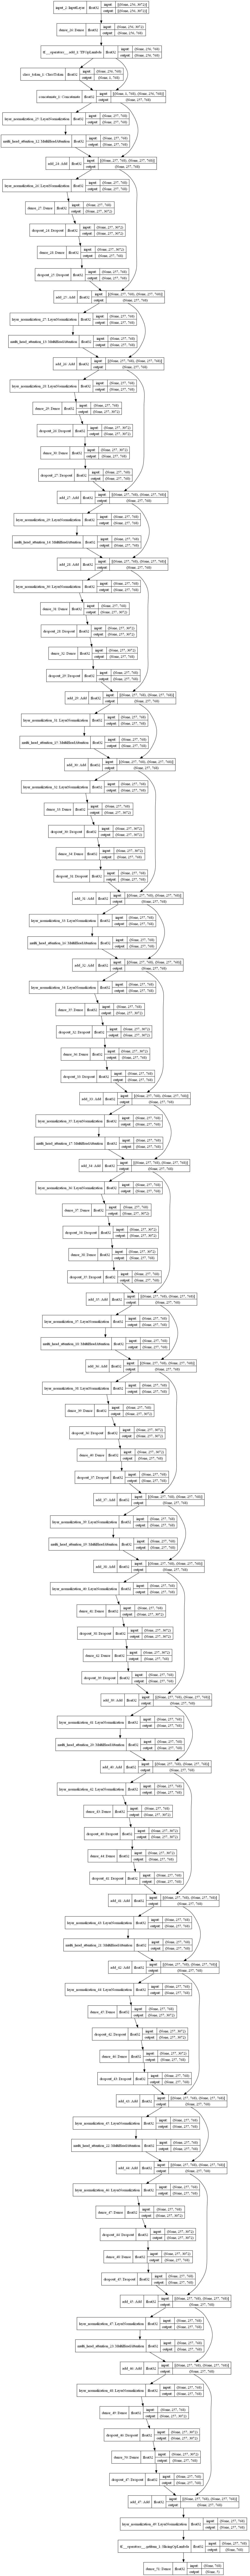

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='ViT-Base.png' ,show_shapes=True,show_dtype=True,show_layer_names=True,expand_nested=True,dpi=96)